Agnieszka Dutka
# Laboratory 5 - Two dimensional patterns

Contents:  
[1. 2d pattern finding](#1)   
[2. Repeating letters pattern in txt](#2)  
[3. th and t h in 2d](#3)   
[4. single letters search in png](#4)  
[5. p a t t e r n search in png](#5)  
[6. Automata creation and search times](#6)  
[7. Search time in chunks](#7)  


In [168]:
import queue
from typing import List
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

<a id='1'></a>
## 1. 2d pattern searching algorithm

#### Structures - Node and Trie

In [169]:
class Node:
    """ each node represents a state """

    def __init__(self, letter, parent=None):
        self.letter = letter
        self.children = {}
        self.parent = parent
        self.ord = None  # number in suffix trie (up-down and left-right)
        self.is_term = False

    def add_child(self, letter):
        self[letter] = Node(letter, parent=self)
        return self[letter]

    def __str__(self):
        T = "[terminal]" if self.is_term else ""
        return f"'{self.letter}' {len(self.children)} children {T}\n"

    def __repr__(self):
        return self.__str__()

    def __setitem__(self, index, value):
        self.children[index] = value

    def __getitem__(self, index):
        return self.children.get(index, None)


class Trie:
    def __init__(self, term_char='$'):
        self.term_char = term_char
        self.root = Node(' ')
        self.size = None  # requires explicit call to get_size_and_nrs!!
        self.nodes_by_nr = {}

    def add_suffix(self, text: str):
        parent = self.root
        i = 0
        child = parent[text[i]]
        while i < len(text) and child:
            parent = child
            child = parent[text[i]]
            i += 1

        while i < len(text):
            parent = parent.add_child(text[i])
            i += 1

        parent.is_term = True  # mark end

    def get_size_and_nrs(self):
        """ traverses trie up-down and left-right, counting trie size and
            numbering nodes"""
        self.size = 0

        q = queue.Queue()
        q.put(self.root)
        while not q.empty():
            curr = q.get()
            for child in curr.children.values():
                q.put(child)
            curr.ord = self.size
            self.nodes_by_nr[self.size] = curr
            self.size += 1

#### Creating transition tables 

In [170]:
def build_trans_tables(alphabet: str, patterns_hor: List[str]):
    """ builds transition table along horizontal patterns and
        transition table of vertical patterns of states 
        :returns: transition table for vertical patterns, 
                  transition table for horizontal patterns,
                  final terminal for 2d pattern"""
    trie = Trie()
    for pattern in patterns_hor:
        trie.add_suffix(pattern)
    trie.get_size_and_nrs()
    term_states_hor = []

    # build vertical transition table, with terminal states for each pattern
    trans_table_vert = [{} for _ in range(trie.size)]
    if trie.root.is_term:
        term_states_hor.append(trie.root)

    for letter in alphabet:
        trans_table_vert[0][letter] = 0

    for state in range(1, trie.size):
        parent = trie.nodes_by_nr[state].parent
        letter = trie.nodes_by_nr[state].letter
        prev_state = trans_table_vert[parent.ord][letter]
        trans_table_vert[parent.ord][letter] = state
        if trie.nodes_by_nr[prev_state].is_term or trie.nodes_by_nr[state].is_term:
            term_states_hor.append(state)
        for letter in alphabet:
            trans_table_vert[state][letter] = trans_table_vert[prev_state][letter]
        for child in trie.nodes_by_nr[prev_state].children.values():
            trans_table_vert[state][child.letter] = child.ord

    pattern_hor = np.zeros(len(patterns_hor))  # pattern created by vertical terminal states
    for i in range(len(patterns_hor)):
        pattern_hor[i] = apply1d(patterns_hor[i], trans_table_vert)[-1]

    # build horizontal transition table, walking on states
    alphabet = np.arange(len(trans_table_vert))  # adding all states as alphabet
    trans_table_hor = [{}]
    for letter in alphabet:
        trans_table_hor[0][letter] = 0
    state = 0
    for pattern_letter in pattern_hor:
        prev_state = trans_table_hor[state][pattern_letter]
        trans_table_hor.append({})
        trans_table_hor[state][pattern_letter] = state + 1
        state += 1
        for letter in alphabet:
            trans_table_hor[state][letter] = trans_table_hor[prev_state][letter]

    return trans_table_vert, trans_table_hor, state  # state - final state for 2d pattern


#### 2d Pattern finding algorithm

In [183]:
def apply1d(text, trans_table_hor) -> np.array:
    """ apply automata algorithm searching for 1d pattern in a 1d structure 
    :param text: 1d structure (here 1d np.array) 
    :param trans_table_hor: list of dicts
    :return: 1d np.array
    """
    states = []
    state = 0
    for letter in text:
        state = trans_table_hor[state][letter]
        states.append(state)

    return np.array(states)


def apply2d(text: np.array, trans_table: np.array, axis=0):
    """ apply automata algorithm searching for 2d pattern in a 2d numpy array (text) 
        specify axis along which the pattern is searched (0 for vertical patterns)"""
    return np.apply_along_axis(lambda c: apply1d(c, trans_table), axis, text)


def find_pattern(text, trans_table_vert, trans_table_hor, terminal):
    """ finds all occurrences (positions) of 2d pattern in 2d text """
    occurrences = []
    states_table_vert = apply2d(text, trans_table_vert, 0)
    # apply automata again on states' table
    states_table_hor = apply2d(states_table_vert, trans_table_hor, 1)

    for r in range(len(states_table_vert)):
        for c in range(len(states_table_vert[r])):
            if states_table_hor[r, c] == terminal:
                occurrences.append((r, c))
    return occurrences


#### easy API

In [172]:
def create_and_find(alphabet, text, pattern2d):
    """ create transition tables and find pattern 
        :returns list of occurrences (positions) """
    trans_table_vert, trans_table_hor, terminal = \
        build_trans_tables(alphabet, [pattern2d[:, c] for c in range(pattern2d.shape[1])])
    return find_pattern(text, trans_table_vert, trans_table_hor, terminal)

def print_result(alphabet, text, pattern, show_pos=False):
    positions = create_and_find(alphabet, text, pattern)
    print(f"pattern: \n{pattern}\n found {len(positions)} times")
    if show_pos and len(positions)>0:
        print(f"found at: \n{positions}\n")

Example usage

In [193]:
example_p = np.array([['a', 'b', 'b'],
                      ['a', 'c', 'b']])

example_t = np.array([['a', 'b', 'b', 'a', 'b', 'b'],
                      ['a', 'a', 'a', 'b', 'b', 'a'],
                      ['b', 'b', 'a', 'c', 'b', 'b'],
                      ['a', 'a', 'b', 'b', 'a', 'b'],
                      ['b', 'a', 'c', 'b', 'b', 'b']])

print_result('abc', example_t, example_p, True)
assert len(create_and_find('abc', example_t, example_p)) == 2

pattern: 
[['a' 'b' 'b']
 ['a' 'c' 'b']]
 found 2 times
found at: 
[(2, 4), (4, 3)]



<a id='2'></a>
### 2. Finding vertically repeating letters in haystack.txt

In [179]:
f = open('haystack.txt')
original = f.readlines()

original = np.array([list(line) for line in original])
lengths = np.array([len(i) for i in original])
mask = np.arange(lengths.max()) < lengths[:,None]
text = np.full(mask.shape, '-')
text[mask] = np.concatenate(original)

alphabet = np.unique(text)
interpunction = [',', '.', ':', ';', '-', '_', ' ', '\"', '\'','\n', "(", ")"]

In [180]:
one_letter_patterns = [np.array([[letter], [letter]]) for letter in alphabet if letter not in interpunction]
for pattern in one_letter_patterns:
    print_result(alphabet, text, pattern)

pattern: 
[['0']
 ['0']]
 found 0 times
pattern: 
[['1']
 ['1']]
 found 0 times
pattern: 
[['3']
 ['3']]
 found 0 times
pattern: 
[['5']
 ['5']]
 found 0 times
pattern: 
[['6']
 ['6']]
 found 0 times
pattern: 
[['7']
 ['7']]
 found 0 times
pattern: 
[['A']
 ['A']]
 found 0 times
pattern: 
[['B']
 ['B']]
 found 0 times
pattern: 
[['C']
 ['C']]
 found 0 times
pattern: 
[['D']
 ['D']]
 found 0 times
pattern: 
[['E']
 ['E']]
 found 0 times
pattern: 
[['F']
 ['F']]
 found 0 times
pattern: 
[['G']
 ['G']]
 found 0 times
pattern: 
[['I']
 ['I']]
 found 0 times
pattern: 
[['L']
 ['L']]
 found 0 times
pattern: 
[['M']
 ['M']]
 found 0 times
pattern: 
[['N']
 ['N']]
 found 0 times
pattern: 
[['O']
 ['O']]
 found 0 times
pattern: 
[['P']
 ['P']]
 found 0 times
pattern: 
[['Q']
 ['Q']]
 found 0 times
pattern: 
[['R']
 ['R']]
 found 0 times
pattern: 
[['S']
 ['S']]
 found 0 times
pattern: 
[['T']
 ['T']]
 found 0 times
pattern: 
[['U']
 ['U']]
 found 0 times
pattern: 
[['V']
 ['V']]
 found 0 times


<a id='3'></a>
### 3. th and t h in 2d

In [47]:
th = np.array([['t', 'h'], ['t', 'h']])
t_h = np.array([['t', ' ', 'h'], ['t', ' ', 'h']])

print_result(alphabet, text, th)
print_result(alphabet, text, t_h, show_pos=True)

pattern: 
[['t' 'h']
 ['t' 'h']]
 found 0 times
pattern: 
[['t' ' ' 'h']
 ['t' ' ' 'h']]
 found 1 times
found at: 
[(38, 2)]



<a id='4'></a>
### 4. Png letters

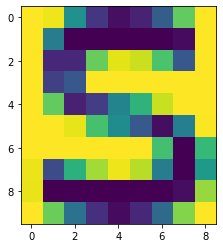

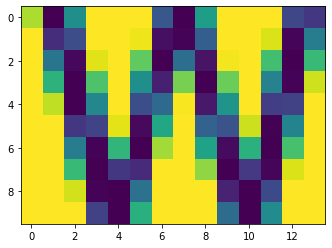

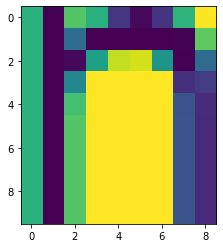

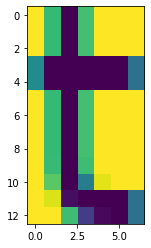

In [181]:
%matplotlib inline
img = np.array(Image.open('haystack.png').convert('L'))
alphabet = np.unique(img)

s = img[37:47,125:134]
w = img[59:69, 48:62]
n = img[37:47, 40:49]
t = img[34:47, 90:97]

plt.imshow(s)
plt.show()
plt.imshow(w)
plt.show()
plt.imshow(n)
plt.show()
plt.imshow(t)
plt.show()

In [182]:
print_result(alphabet, img, s)
print_result(alphabet, img, w)
print_result(alphabet, img, t)
print_result(alphabet, img, n)

pattern: 
[[255 249 129  40  10  25  75 194 255]
 [255 107   0   0   0   0   0   7 255]
 [255  28  28 196 245 235 183  70 255]
 [255  48  70 255 255 255 255 255 255]
 [255 194  23  46 115 166 234 255 255]
 [255 255 246 181 124  71   9 110 254]
 [255 255 255 255 255 255 179   0 171]
 [248  58 164 220 249 228 107   0 138]
 [247   0   0   0   0   0   0   9 216]
 [255 198  95  35   7  28  88 208 255]]
 found 314 times
pattern: 
[[224   0 127 255 255 255  69   0 143 255 255 255  54  41]
 [255  33  60 255 255 249  10   2  76 255 255 241   3 107]
 [255  99   5 244 255 193   0  92  13 251 255 178   0 173]
 [255 165   0 184 255 127  22 203   0 198 255 113   2 237]
 [255 231   0 118 255  61  87 253  17 132 255  47  49 255]
 [255 255  41  52 245   6 153 255  80  65 236   1 115 255]
 [255 255 107   2 168   0 220 255 147   7 163   0 181 255]
 [255 255 173   0  41  30 255 255 213   0  42   4 242 255]
 [255 255 238   2   0  96 255 255 255  24   0  57 255 255]
 [255 255 255  50   0 162 255 255 255  90

<a id='5'></a>
### 5. p a t t e r n search in png

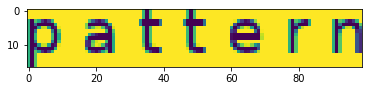

In [142]:
pattern = img[628:645,248:347]
plt.imshow(pattern)
plt.show()

In [113]:
print_result(alphabet, img, pattern)

pattern: 
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [163   0 187 ... 255 255 255]
 [163   0 187 ... 255 255 255]
 [163   0 187 ... 255 255 255]]
 found 5 times


<a id='6'></a>
### 6. Time evaluation

In [132]:
from typing import Callable
from time import perf_counter

def time_eval(func: Callable, name, times,  *args, **kwargs):
    start_pc = perf_counter()
    res = []
    for i in range(times):
        res = func(*args, **kwargs)
    end_pc = perf_counter()
    avg_pc = (end_pc-start_pc)/times
    if name is not None:
        print(name, "time:", round(avg_pc, 6))
    return avg_pc, res

In [162]:
def time_for_pattern(text, pattern2d, alphabet, times=2):
    t1, res = time_eval(build_trans_tables, "building", times, \
                          alphabet, pattern2d)
    t2, _ = time_eval(find_pattern, "finding pattern", times, text, *res) 
    return t1, t2


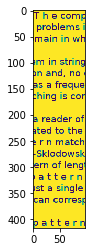

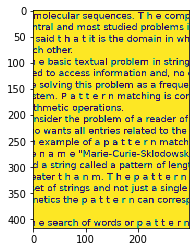

In [149]:
chunk = img[228:645,248:347]
plt.imshow(chunk)
plt.show()

big_chunk = img[228:645,48:347]
plt.imshow(big_chunk)
plt.show()

In [156]:
s1 = s.shape[0]*s.shape[1]
print(f"pattern size: {s1}")
t1, _ = time_for_pattern(img, s, alphabet)

s2 = pattern.shape[0]*pattern.shape[1]
print(f"\npattern size: {s2}")
t2, _ = time_for_pattern(img, pattern, alphabet)

s3 = chunk.shape[0]*chunk.shape[1]
print(f"\npattern size: {s3}")
t3, _ = time_for_pattern(img, chunk, alphabet)

s4 = big_chunk.shape[0]*big_chunk.shape[1]
print(f"\npattern size: {s3}")
t4, _ = time_for_pattern(img, big_chunk, alphabet)

print(t1/s1, t2/s2, t3/s3, t4/s4)

pattern size: 90
building time: 0.006903
finding pattern time: 1.433201

pattern size: 1683
building time: 0.014819
finding pattern time: 1.47984

pattern size: 41283
building time: 1.731788
finding pattern time: 1.533187

pattern size: 41283
building time: 6.082607
finding pattern time: 1.534228
7.669944444488566e-05 8.805139631559458e-06 4.194917278298672e-05 4.878457688698654e-05


Można zauważyć, że czas tworzenia struktury do wyszukiwania danego wzorca jest w przybliżeniu liniowy (gdyż iloraz wielkości wzorca do czasu tworzenia jest stały (z dokładnością do rzędu wielkości))   
Czas wyszukiwania wzorca w danym tekście zależy tylko od wielkości tekstu, a nie zależy od wzorca

<a id='7'></a>
### 7. Time evaluation for smaller chunks

In [163]:
ln = img.shape[0]

def by_parts(img, pattern, alphabet, nr):
    ln = img.shape[0]
    whole = 0.
    for chunk in range(nr):
        _, t =time_for_pattern(img[ln*chunk//nr:ln*(chunk+1)//nr], pattern, alphabet)
        whole += t
    print(f"whole search time {whole}\n")

by_parts(img, pattern, alphabet, 2)
by_parts(img, pattern, alphabet, 4)
by_parts(img, pattern, alphabet, 8)

building time: 0.014496
finding pattern time: 0.722068
building time: 0.014655
finding pattern time: 0.728598
whole search time 1.4506657000001724

building time: 0.014639
finding pattern time: 0.356231
building time: 0.014868
finding pattern time: 0.36568
building time: 0.014295
finding pattern time: 0.369479
building time: 0.014451
finding pattern time: 0.360563
whole search time 1.4519537999999557

building time: 0.014326
finding pattern time: 0.185961
building time: 0.014732
finding pattern time: 0.196298
building time: 0.014704
finding pattern time: 0.191705
building time: 0.014946
finding pattern time: 0.183517
building time: 0.014489
finding pattern time: 0.186046
building time: 0.014861
finding pattern time: 0.18601
building time: 0.014385
finding pattern time: 0.183966
building time: 0.014591
finding pattern time: 0.190555
whole search time 1.5040579500000604



Wyniki pokazują, że czas przeszukiwania jest liniowy w zależności od wielkości tekstu